In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from SafeBayes import SafeBayesLinearRegression
from experiment_tools import experiment,square_risk

## Import data

In [6]:
file = "data/avg_price_elec.csv"
data = pd.read_csv(file)

def fourier_basis(X, k_max=50):
    return np.vstack([X] + [np.cos(2*np.pi*k*X) for k in range(k_max)] + [np.sin(2*np.pi*k*X) for k in range(k_max)]).T

def generate_covariate(data, name_y = "price",k_max = 50):
    X = data["time"].to_numpy()
    y = data[name_y].to_numpy()
    y = ( y - np.min(y) ) / ( np.max(y)- np.min(y) ) -.5 # Renormalizing y

    N = len(y)
    X = fourier_basis(X, k_max)
    rng = np.random.default_rng()
    ind = np.arange(N)
    rng.shuffle(ind)
 
    return X[ind[:N//2]],y[ind[:N//2]],X[ind[N//2:]],y[ind[N//2:]], 

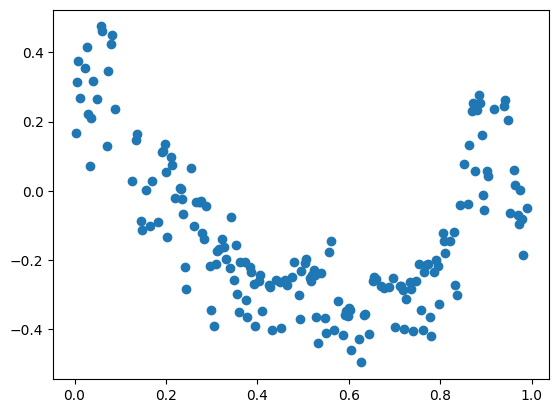

In [7]:
X,y,X_test,y_test = generate_covariate(data, name_y = "charge")
plt.scatter(X[:,0],y)
plt.show()

## Run experiment

In [8]:
k_fourier_basis = 52 # 52 week in a year
number_run = 30
all_risk = []
for _ in tqdm(range(number_run)):
    X,y,X_test,y_test = generate_covariate(data, name_y = "charge",k_max=k_fourier_basis)
    all_risk.append(experiment(X, y,X_test,y_test, step_size=1, k_max=16, pmax=k_fourier_basis*2, sigma2=1/40))
all_risk = np.stack(all_risk)
average_over_run_square_risks = np.mean(all_risk,axis=2)
number_of_samples_used = np.arange(2,len(X)+1)

100%|██████████| 30/30 [08:31<00:00, 17.06s/it]


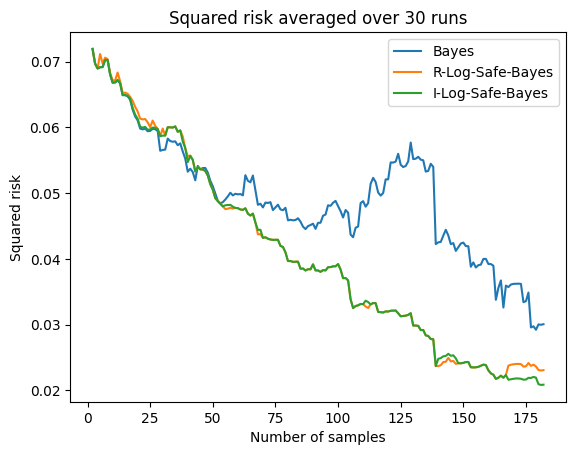

In [9]:
plt.figure()
plt.plot(number_of_samples_used,all_risk[0],label = ["Bayes","R-Log-Safe-Bayes","I-Log-Safe-Bayes"])
plt.xlabel("Number of samples")
plt.ylabel("Squared risk")
plt.legend()
plt.title(f"Squared risk averaged over {number_run} runs")
plt.title
plt.show()

## Plot regression function

In [34]:
k_fourier_basis = 52 # 52 week in a year
num_samples = 125
X,y,X_test,y_test = generate_covariate(data, name_y = "charge",k_max=k_fourier_basis)
X,y = X[:num_samples],y[:num_samples]
safe_bayes_R = SafeBayesLinearRegression(loss = 'RLogLoss', a0 = 1, b0 = 1/40, pmax=k_fourier_basis*2)
safe_bayes_I = SafeBayesLinearRegression(loss = 'ILogLoss', a0 = 1, b0 = 1/40, pmax=k_fourier_basis*2)

beta_bayes,_ = safe_bayes_R.GeneralizedPosteriors(X,y,1)
beta_safe_R, sigma_R, eta_R = safe_bayes_R.fit(X,y)
beta_safe_I, sigma_I, eta_I = safe_bayes_I.fit(X,y)
print("eta R : " , eta_R, " - eta I : ", eta_I)


eta R :  0.1088188204120155  - eta I :  0.051952368508924235


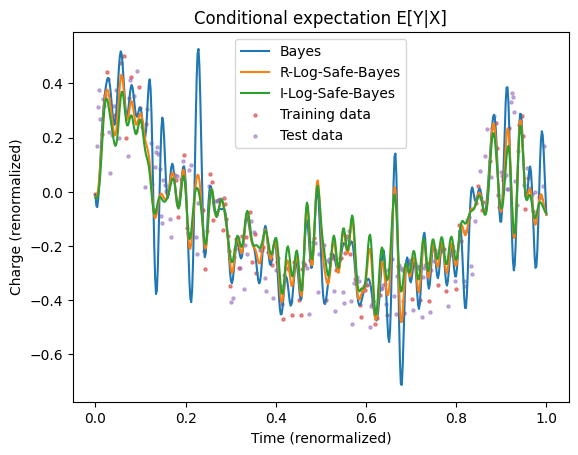

Squared risk standard bayes : 0.0442 
Squared risk R safe bayes : 0.0242 
Squared risk I safe bayes : 0.0244


In [50]:
X_plot = np.linspace(0,1,500)
X_plot = fourier_basis(X_plot, k_max=k_fourier_basis)
y_bayes_plot = X_plot @ beta_bayes[0]
y_safe_bayes_R_plot = X_plot @ beta_safe_R[0]
y_safe_bayes_I_plot = X_plot @ beta_safe_I[0]

plt.figure()
plt.plot(X_plot[:,0],np.vstack([y_bayes_plot,y_safe_bayes_R_plot,y_safe_bayes_I_plot]).T,label = ["Bayes","R-Log-Safe-Bayes","I-Log-Safe-Bayes"])
plt.scatter(X[:,0],y,label = "Training data",s = 5,alpha =.5,color = '#d62728')
plt.scatter(X_test[:,0],y_test, label = "Test data",s = 5,alpha =.5,color = '#9467bd')
plt.xlabel("Time (renormalized)")
plt.ylabel("Charge (renormalized)")
plt.title("Conditional expectation E[Y|X]")
plt.legend()

plt.show()

print(f"Squared risk standard bayes : {square_risk(beta_bayes[0],X_test,y_test):.4f}",
      f"\nSquared risk R safe bayes : {square_risk(beta_safe_R[0],X_test,y_test):.4f}",
      f"\nSquared risk I safe bayes : {square_risk(beta_safe_I[0],X_test,y_test):.4f}")